In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
# rcParams['figure.figsize'] = 10, 8
# rcParams['figure.dpi'] = 300

import torch
from torch import nn
from torch import distributions

In [2]:
from gan import TripletNet, ManipulableAutoEncoder, Generator
from real_nvp import train_real_nvp
from torchvision import transforms
import torchvision.transforms.functional as TF
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

device = "cpu"
tripletnet = TripletNet().to(device)
tripletnet.load_state_dict(torch.load("./mnist_results/gen_manipulable_ae_v4_perceptual_wgan-gp/mnist_tripletnet_state_dict.pth"))
tripletnet.eval()

manipulable_ae = ManipulableAutoEncoder().to(device)
manipulable_ae.load_state_dict(torch.load("./mnist_results/gen_manipulable_ae_v4_perceptual_wgan-gp/mnist_manipulable_ae_state_dict.pth"))
manipulable_ae.eval()

gen = Generator().to(device)
gen.load_state_dict(torch.load("./mnist_results/gen_manipulable_ae_v4_perceptual_wgan-gp/mnist_gen_state_dict.pth"))
gen.eval()

Generator(
  (main): Sequential(
    (0): Linear(in_features=16, out_features=1568, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=1568, out_features=1568, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Reshape()
    (5): WSConv2d(
      (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Resize()
    (8): LeakyReLU(negative_slope=0.2)
    (9): WSConv2d(
      (conv): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (10): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Resize()
    (12): LeakyReLU(negative_slope=0.2)
    (13): WSConv2d(
      (conv): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (14): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Le

### 1. Train 16d Distribution by Normalizing Flow

In [3]:
trainset = MNIST(
    root="./MNIST/images/",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

validset = MNIST(
    root="./MNIST/images/",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [4]:
codes = []

for x, y in trainset:
    pred = tripletnet(x.to(device).unsqueeze(0))
    codes.append(pred.detach())

In [5]:
codes[0].shape

torch.Size([1, 16])

In [6]:
print(len(codes))

60000


In [7]:
codes[0]

tensor([[ 26.1038,  18.5009, -14.2154, -11.3177, -23.1122, -40.2860,  28.7090,
          -3.2100,  -9.5845, -18.6755, -30.6731,   7.5210,   5.9321,  15.5998,
          33.9703,  15.4848]])

In [8]:
from time import time
start_time = time()

flow = train_real_nvp(codes, iters=10000)
samples = flow.sample(100000)
codes_2d = []

for sample in samples:
    codes_2d.append(manipulable_ae.encode(sample.unsqueeze(0)).reshape(-1).detach())

elapsed_time = int(time() - start_time)

print(f"elapsed_time: {elapsed_time//3600}h {elapsed_time%3600//60}m {elapsed_time%60}s")

iter 0 loss = 206.058
iter 500 loss = 25.859
iter 1000 loss = 24.208
iter 1500 loss = 24.333
iter 2000 loss = 25.009
iter 2500 loss = 21.423
iter 3000 loss = 22.290
iter 3500 loss = 20.044
iter 4000 loss = 20.755
iter 4500 loss = 21.543
iter 5000 loss = 20.210
iter 5500 loss = 18.102
iter 6000 loss = 21.987
iter 6500 loss = 16.564
iter 7000 loss = 16.298
iter 7500 loss = 15.690
iter 8000 loss = 14.858
iter 8500 loss = 15.221
iter 9000 loss = 16.057
iter 9500 loss = 16.912
elapsed_time: 2h 20m 35s


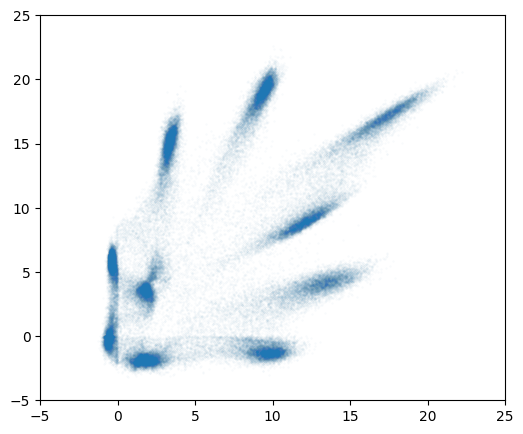

In [12]:
plt.figure(figsize=(6, 5))
plt.scatter([codes_2d[i][0].item() for i in range(len(codes_2d))], [codes_2d[i][1].item() for i in range(len(codes_2d))], s=0.1, alpha=0.05)
plt.xlim((-5, 25))
plt.ylim((-5, 25))
# plt.gca().invert_yaxis()
plt.show()

In [8]:
from time import time
start_time = time()

flow = train_real_nvp(codes)
samples = flow.sample(100000)
codes_2d = []

for sample in samples:
    codes_2d.append(manipulable_ae.encode(sample.unsqueeze(0)).reshape(-1).detach()) 

elapsed_time = int(time() - start_time)

print(f"elapsed_time: {elapsed_time//3600}h {elapsed_time%3600//60}m {elapsed_time%60}s")

iter 0 loss = 99.098
iter 500 loss = -7.703
iter 1000 loss = -14.496
iter 1500 loss = -17.741
iter 2000 loss = -18.358
iter 2500 loss = -19.749
iter 3000 loss = -19.553
iter 3500 loss = -21.189
iter 4000 loss = -22.249
iter 4500 loss = -23.952
iter 5000 loss = -22.785
iter 5500 loss = -23.683
iter 6000 loss = -24.130
iter 6500 loss = -25.353
iter 7000 loss = -25.766
iter 7500 loss = -25.574
iter 8000 loss = -25.726
iter 8500 loss = -26.162
iter 9000 loss = -26.147
iter 9500 loss = -26.554
iter 10000 loss = -27.214
elapsed_time: 3h 27m 32s


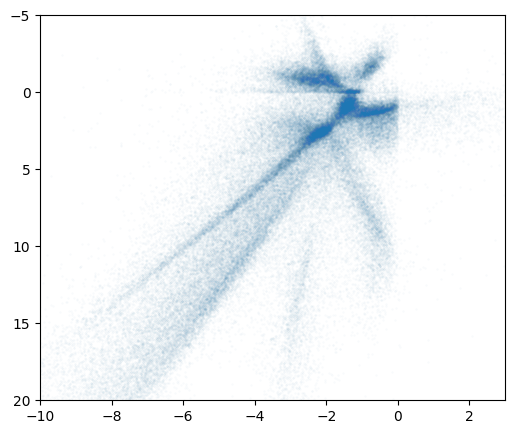

In [25]:
plt.figure(figsize=(6, 5))
plt.scatter([codes_2d[i][0].item() for i in range(len(codes_2d))], [codes_2d[i][1].item() for i in range(len(codes_2d))], s=0.1, alpha=0.05)
plt.xlim((-10, 3))
plt.ylim((-5, 20))
plt.gca().invert_yaxis()
plt.show()

In [ ]:
flow = train_real_nvp(codes)
samples = flow.sample(100000)
codes_2d = []

for sample in samples:
    codes_2d.append(manipulable_ae.encode(sample.unsqueeze(0)).reshape(-1).detach()) 

iter 0 loss = 156.199
iter 500 loss = 2.413
iter 1000 loss = -0.856
iter 1500 loss = -1.354
iter 2000 loss = -1.410
iter 2500 loss = -4.998
iter 3000 loss = -5.363
iter 3500 loss = -3.011
iter 4000 loss = 9.058
iter 4500 loss = -8.345
iter 5000 loss = -4.131
iter 5500 loss = -8.159
iter 6000 loss = -10.249
iter 6500 loss = -9.712
iter 7000 loss = -11.156
iter 7500 loss = -12.073
iter 8000 loss = -12.282
iter 8500 loss = -2.172
iter 9000 loss = -12.479
iter 9500 loss = -10.663
iter 10000 loss = -12.375


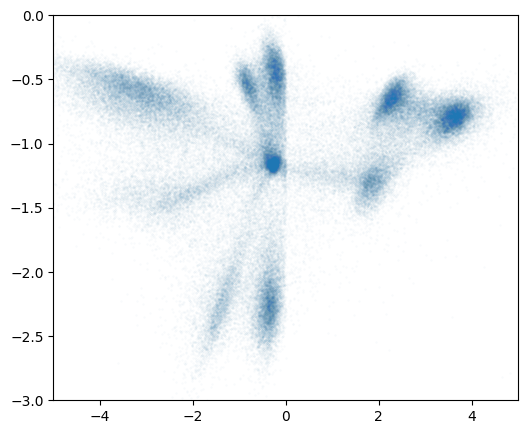

In [9]:
plt.figure(figsize=(6, 5))
plt.scatter([codes_2d[i][0].item() for i in range(len(codes_2d))], [codes_2d[i][1].item() for i in range(len(codes_2d))], s=0.1, alpha=0.05)
plt.xlim((-5, 5))
plt.ylim((0, -3.0))
plt.gca().invert_yaxis()
plt.show()

#### - Visualize samples

In [17]:
pred = gen(samples[-100:])
print(pred.shape)

torch.Size([100, 1, 28, 28])


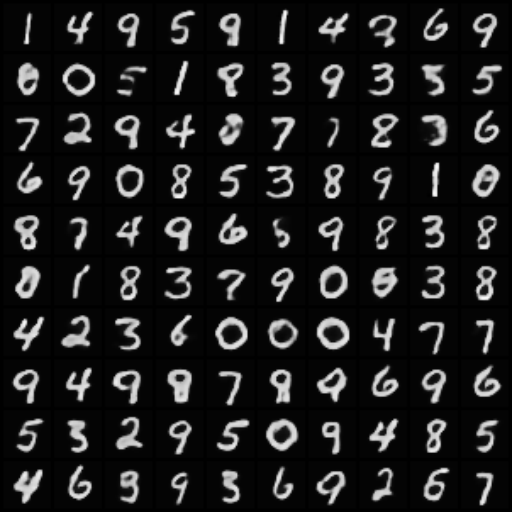

In [18]:
# grid = make_grid(pred, nrow=10)
grid = make_grid(pred, nrow=10, normalize=True)
img = TF.resize(TF.to_pil_image(grid), (512, 512))
img

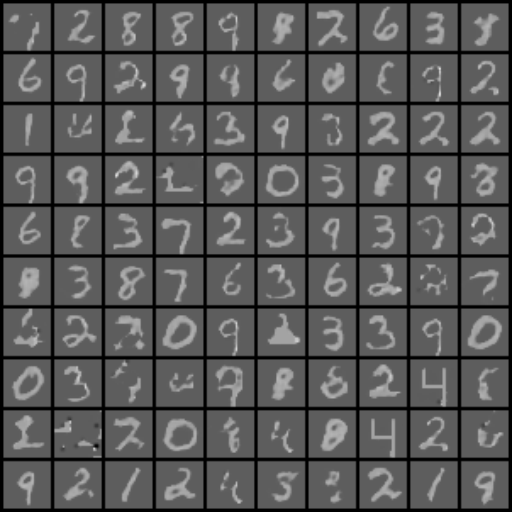

In [12]:
# grid = make_grid(pred, nrow=10)
grid = make_grid(pred, nrow=10, normalize=True)
img = TF.resize(TF.to_pil_image(grid), (512, 512))
img

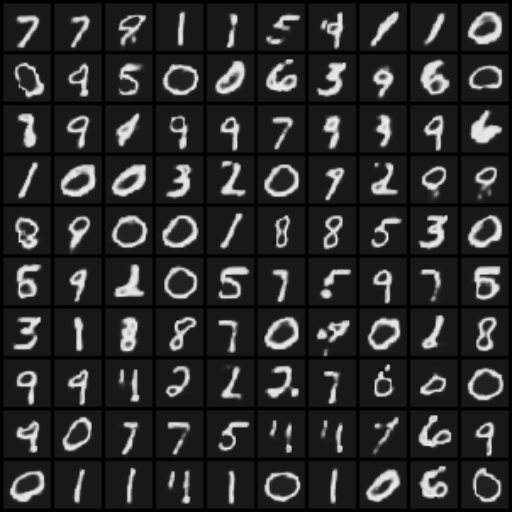

In [11]:
# grid = make_grid(pred, nrow=10)
grid = make_grid(pred, nrow=10, normalize=True)
img = TF.resize(TF.to_pil_image(grid), (512, 512))
img

### 2. Manipulate Distribution

### 3. Interpolation

Text(0.5, 1.0, '$X = g(z)$')

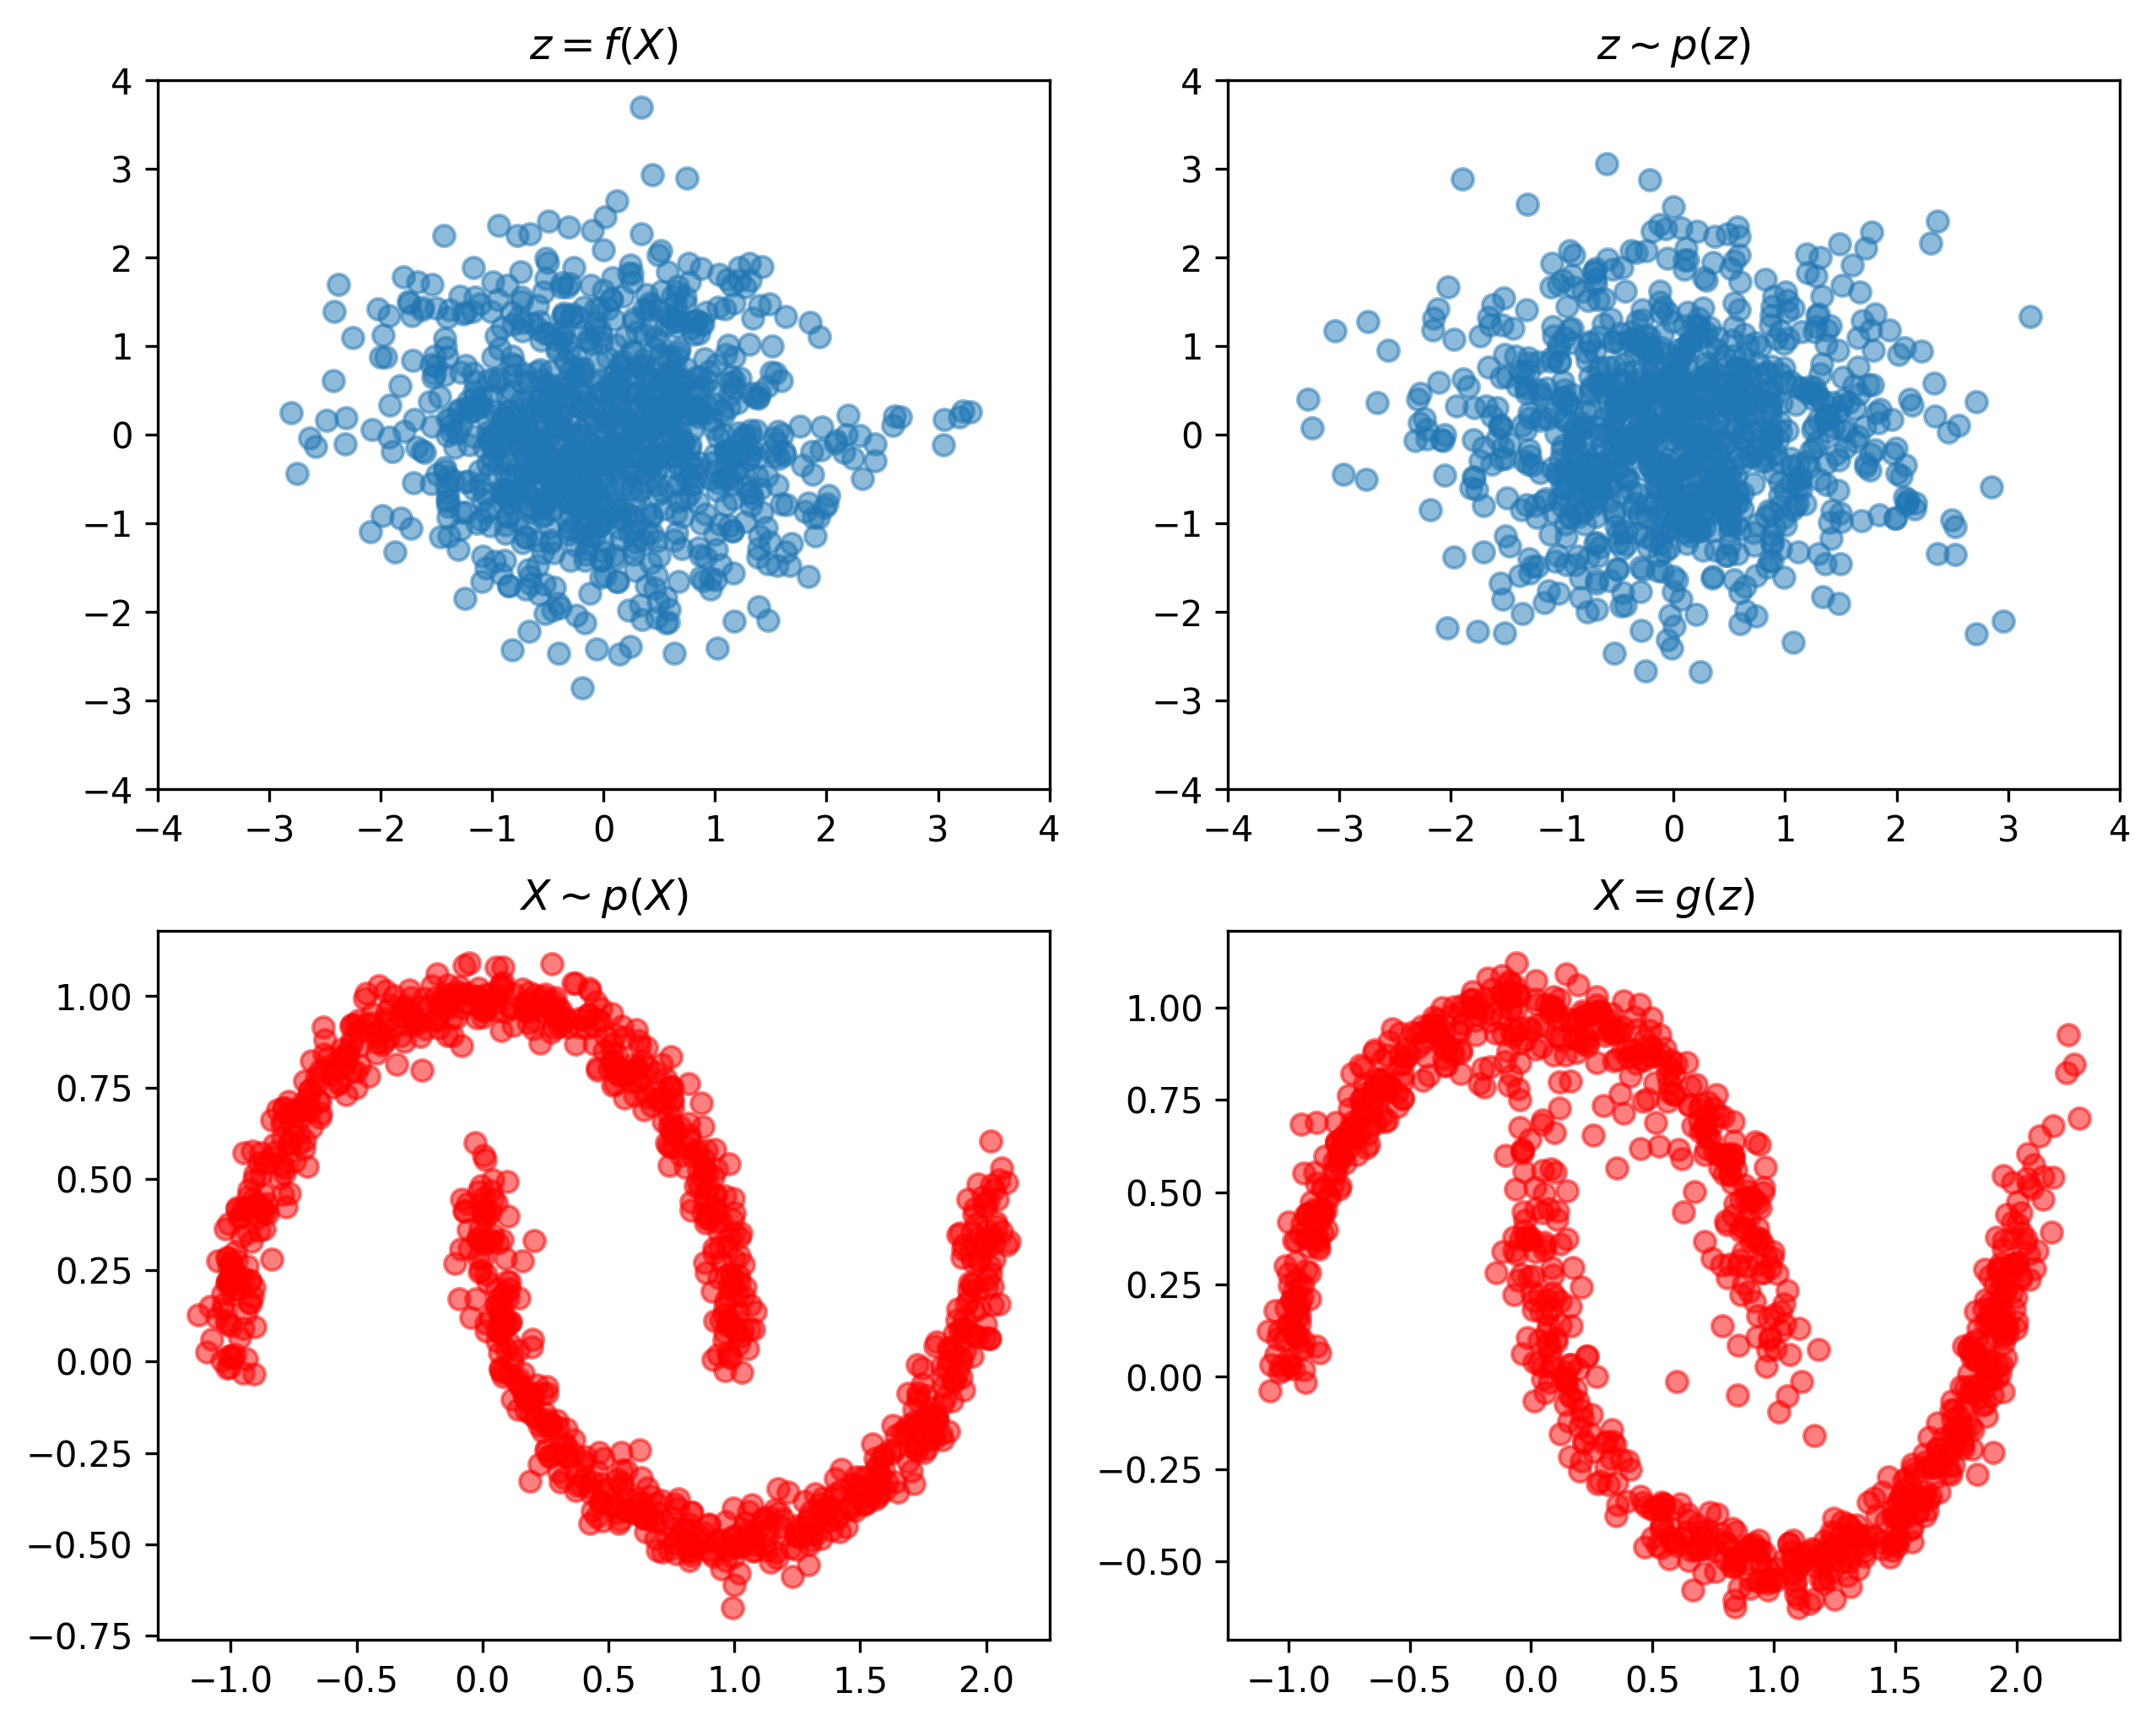

In [38]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1], alpha=0.5)
plt.xlim((-4, 4))
plt.ylim((-4, 4))
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1], alpha=0.5)
plt.xlim((-4, 4))
plt.ylim((-4, 4))
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r', alpha=0.5)
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r', alpha=0.5)
plt.title(r'$X = g(z)$')